In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import math
import os
from pathlib import Path
import sys

In [3]:
from PIL import Image as PILImage
from PIL import ImageChops as PILImageChops
from fastai import *
from fastai.vision import *
from fastai.vision.transform import *
from fastai.vision.image import TfmAffine
from fastai.metrics import accuracy
from torchvision.transforms import functional as vision_transform

In [4]:
parent_dir = Path.cwd().parent.as_posix()
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [5]:
from basedir import PREPARED, TEST
from dataset import QuickDraw, TestImagesFolder
from logger import get_logger
from utils import Timer

In [6]:
defaults.device = torch.device('cuda:1')
log = get_logger(log_path='log.txt')

In [7]:
trn_ds = QuickDraw(PREPARED, train=True, subset_size=100, log=log)
val_ds = QuickDraw(PREPARED, train=False, subset_size=100, log=log)
tst_ds = TestImagesFolder(TEST)

[2018/11/15 23:03:09:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/train_100.feather
[2018/11/15 23:03:09:INFO    ] Reading cached data from /home/ck/data/doodle/prepared/cache/valid_100.feather


In [8]:
def trim(img):
    bg = PILImage.new(img.mode, img.size, color='black')
    diff = PILImageChops.difference(img, bg)
    diff = PILImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        img = img.crop(bbox)
    return img

In [9]:
@TfmCrop
def strip_empty_space(x, size, **kwargs):
    """Crops the image to exclude empty space from the image and rescale it to oritinal size."""
    
    img = vision_transform.to_pil_image(x)
    trimmed = trim(img).resize(size)
    new = vision_transform.to_tensor(trimmed).to(x)
    return new

In [10]:
def mapk(y_pred, y_true, k):
    """Precision metric which compares several guesses with a single ground-truth value.
    
    Adapted from:
        https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
        
    """
    top_k = y_pred.argsort(descending=True)[:, :k]
    matched = top_k == y_true.view(-1, 1)
    map_k = 1/(matched.argmax(dim=1) + 1).float()
    return map_k.mean()

In [11]:
def show_batch(data_bunch, ds_type=DatasetType.Train, n=9, **fig_kwargs):
    dl = data_bunch.dl(ds_type)
    index = next(iter(dl.batch_sampler))[:n]
    rows = int(math.sqrt(len(index)))
    cols = n // rows
    ds = dl.dataset
    images = [ds[i][0] for i in index]
    f, axes = plt.subplots(rows, cols, **fig_kwargs)
    for img, ax in zip(images, axes.flat):
        ax.imshow(img.data.permute(1, 2, 0))
        ax.set_axis_off()

In [12]:
train_tfms = [
    strip_empty_space(),
    rand_crop(padding_mode='zeros'),
    flip_affine(p=0.5),
    rotate(degrees=(-5, 5), p=0.75),
    rand_zoom(scale=(0.8, 1.1), p=0.5)
]

valid_tfms = [
    crop_pad(padding_mode='zeros')
]

ds_tfms = train_tfms, valid_tfms

In [13]:
bunch = ImageDataBunch.create(trn_ds, val_ds, tst_ds, bs=300, ds_tfms=ds_tfms).normalize(imagenet_stats)

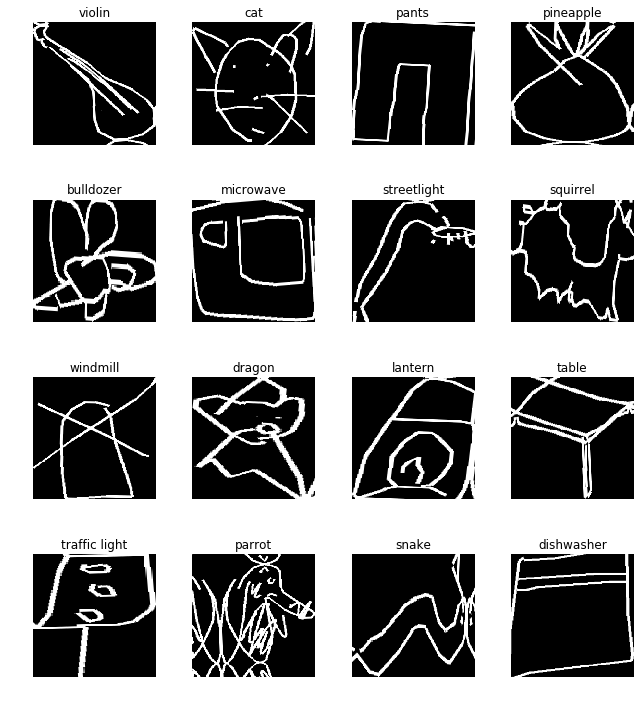

In [14]:
bunch.show_batch(rows=4)

In [15]:
learn = create_cnn(bunch, models.resnet18)

In [16]:
learn.metrics = [partial(mapk, k=3)]

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,mapk


In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1)

In [ ]:
def top_k(learn, logits, k=3):
    top_idx = logits.argsort()[:, -k:]
    top_classes = learn.data.classes[top_idx]
    top_logits = logits[np.arange(len(logits)), top_idx.T].T
    return np.fliplr(top_classes), np.fliplr(top_logits)